## Connecting to the Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
cd gdrive/MyDrive/FaceEmotionDetection

/content/gdrive/MyDrive/FaceEmotionDetection


In [3]:
ls

emotion_data.csv           emotion_model_weight.h5          test/
emotion_image1.pickle      FaceEmotionDetectionFinal.ipynb  train/
emotion_image.pickle       images/                          train_model.png
emotion_image_test.pickle  photo.jpg
emotion_model.json         predicted_emotion_data.csv


## Importing the Libraries required

In [4]:
import numpy as np
import pandas as pd
import os
import cv2
import glob
import tensorflow as tf
from matplotlib import pyplot
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import plot_model
from tqdm import tqdm  
from tensorflow.keras.utils import img_to_array 
from tensorflow.keras.models import load_model, model_from_json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import pickle   
import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Data Summary

In [5]:
test_path = 'test/' 
train_path = 'train/'

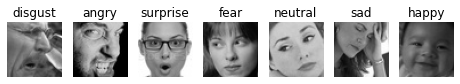

In [8]:
# To get the sample of the images from each category of test data
i = 1
plt.figure(figsize=(8,8))
for expressions in os.listdir(test_path):
    
    image = load_img((test_path + expressions +'/' + os.listdir(test_path + expressions)[5]))
    plt.subplot(1,7,i)
    plt.imshow(image)
    plt.title(expressions)
    plt.axis('off')
    i += 1
    
plt.show()

In [ ]:
# Function to get the count of the images present in each category of both test and train dataset.
def count_expr(path, set_):
    dictionary = {}
    for expressions in os.listdir(path):
        directory = path + expressions
        dictionary[expressions] = len(os.listdir(directory))
    df = pd.DataFrame(dictionary, index=[set_])
    return df

In [ ]:
train_count = count_expr(train_path, 'train')
print("Count of Image Samples in Training Dataset:\n")
print(train_count)
print("____________________________________________________________")
test_count = count_expr(test_path, 'test')
print("Count of Image Samples in Testing Dataset:\n")
print(test_count)

Count of Image Samples in Training Dataset:

        sad  neutral  fear  angry  happy  surprise  disgust
train  4837     4965  4097   3996   7215      3171      436
____________________________________________________________
Count of Image Samples in Testing Dataset:

      disgust  angry  surprise  fear  neutral   sad  happy
test      111    958       831  1024     1233  1247   1774


## Data Manipulation

In [ ]:
emotions = ['angry','disgust','fear','happy','neutral','surprise','sad']

In [ ]:
# Function to get label the emotions accordingly
def label(x):
    if x == "angry":
        return 0
    if x == "disgust":
        return 1
    if x == "fear":
        return 2
    if x == "happy":
        return 3
    if x == "neutral":
        return 4
    if x == "surprise":
        return 5
    if x == "sad":
        return 6

### Converting the images into CSV format 

In [ ]:
temp = pd.DataFrame()
path = []
emotion = []

In [ ]:
for e in emotions:
    path.extend(glob.glob('train/' + e +'/*.jpg'))

In [ ]:
len(path)

28716

In [ ]:
temp['path'] = path

In [ ]:
for i in path:
    emotion.append(i.split('/')[-2])

In [ ]:
temp['emotion'] = emotion

In [ ]:
temp.head(5)

,path,emotion
0,train/angry/Training_54806380.jpg,angry
1,train/angry/Training_86750647.jpg,angry
2,train/angry/Training_58773233.jpg,angry
3,train/angry/Training_60412371.jpg,angry
4,train/angry/Training_99819558.jpg,angry


In [ ]:
train_data = temp

In [ ]:
train_data['emotion_label'] = train_data['emotion'].apply(label)

In [ ]:
train_data = train_data.drop(['emotion'], axis=1)

In [ ]:
train_data.shape

(28716, 2)

In [ ]:
train_data.sample()

,path,emotion_label
7921,train/fear/Training_17780351.jpg,2


In [ ]:
temp = pd.DataFrame()
path = []
emotion = []

In [ ]:
for e in emotions:
    path.extend(glob.glob('test/' + e +'/*.jpg'))

In [ ]:
len(path)

7178

In [ ]:
temp['path'] = path

In [ ]:
for i in path:
    emotion.append(i.split('/')[-2])

In [ ]:
temp['emotion'] = emotion

In [ ]:
temp.head(5)

,path,emotion
0,test/angry/PrivateTest_56780735.jpg,angry
1,test/angry/PrivateTest_20789399.jpg,angry
2,test/angry/PublicTest_54144300.jpg,angry
3,test/angry/PrivateTest_71268050.jpg,angry
4,test/angry/PublicTest_47434180.jpg,angry


In [ ]:
test_data = temp

In [ ]:
test_data['emotion_label'] = test_data['emotion'].apply(label)

In [ ]:
test_data = test_data.drop(['emotion'], axis=1)

In [ ]:
test_data.shape

(7178, 2)

In [ ]:
test_data.sample()

,path,emotion_label
5832,test/surprise/PrivateTest_53302575.jpg,5


In [ ]:
data = [train_data, test_data]

In [ ]:
final_data = pd.concat(data)

In [ ]:
final_data.shape

(35894, 2)

In [ ]:
#final_data.to_csv("emotion_data.csv", index = False)

In [ ]:
emotion_data = pd.read_csv("emotion_data.csv")

In [ ]:
emotion_data.sample()

,path,emotion_label
30540,test/fear/PublicTest_42755313.jpg,2


In [ ]:
# Taking only the 0.40 fraction of the whole 35894 data
emotion_data = emotion_data.drop(emotion_data[emotion_data['emotion_label'] != 1].sample(frac=.40).index)

In [ ]:
emotion_data['emotion_label'].value_counts()

3    5316
4    3768
6    3698
2    3092
0    2958
5    2376
1     547
Name: emotion_label, dtype: int64

In [ ]:
emotion_data.shape

(21755, 2)

## Data Augmentation and Processing


In [ ]:
# Function to convert the images into an array
from multiprocessing import Pool
progress = tqdm(total= len(emotion_data['path']), position=0)
def read(path):
  img = tf.keras.utils.load_img(path, target_size=(48,48,3))
  img = tf.keras.utils.img_to_array(img)
  img = img/255.
  progress.update(1)
  return img

p = Pool(10)
img_array = p.map(read, emotion_data['path'])

 10%|▉         | 2165/21755 [00:24<01:28, 222.36it/s]

In [ ]:
# Saving the function to a pickle file for easy access
with open('emotion_image.pickle','wb') as f:
  pickle.dump(img_array, f)

In [ ]:
with open('emotion_image.pickle','rb') as f:
  img_array = pickle.load(f)

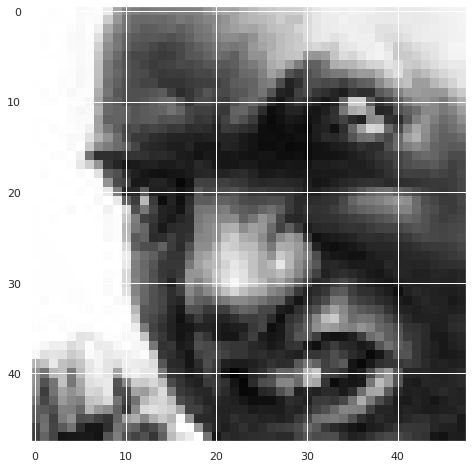

In [ ]:
plt.imshow(img_array[1204])

In [ ]:
X = img_array
y = emotion_data['emotion_label'].values

(<matplotlib.image.AxesImage at 0x7efc2842e640>, 0)

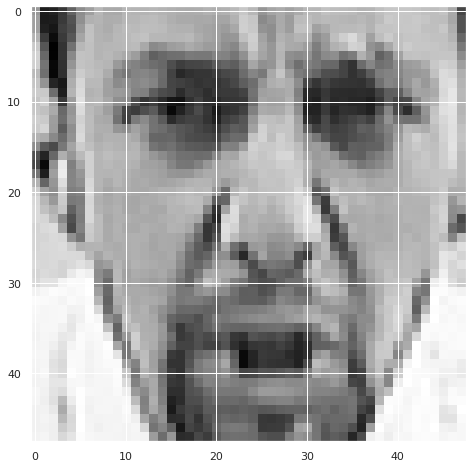

In [ ]:
plt.imshow(X[0]),y[0]

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
X.shape, y.shape

((21755, 48, 48, 3), (21755,))

In [ ]:
# Processing the data by flipping the images vertically as well as horizontally
processed_train_data = []
processed_target_train = []
for i in range(X.shape[0]):
  processed_train_data.append(X[i])
  #processed_train_data.append(rotate(X[i], angle=45, mode = 'wrap'))
  processed_train_data.append(np.fliplr(X[i]))
  processed_train_data.append(np.flipud(X[i]))
  for j in range(3):
      processed_target_train.append(y[i])

In [ ]:
len(processed_train_data), len(processed_target_train)

(65265, 65265)

In [ ]:
# Saving the processed images to a pickle file
with open('emotion_image1.pickle','wb') as f:
  pickle.dump([processed_train_data, processed_target_train], f)

In [ ]:
with open('emotion_image1.pickle','rb') as f:
  processed_train_data, processed_target_train = pickle.load(f)

In [ ]:
processed_train_data = np.array(processed_train_data)
processed_target_train = np.array(processed_target_train)

In [ ]:
processed_train_data.shape, processed_target_train.shape

((65265, 48, 48, 3), (65265,))

In [ ]:
#Splitting the processed data into test and train to train a model
X_train, X_test, y_train, y_test = train_test_split(processed_train_data, processed_target_train, random_state = 42, test_size = 0.3)

In [ ]:
X_train.shape

(45685, 48, 48, 3)

## Data Modelling

In [ ]:
BATCH_SIZE = 64
IMG_SHAPE = 48 # square image

In [ ]:
# Input shape is 48, 48, 1 since our image pixels is 48*48
input_shape = (48, 48, 3)

def create_model(inpt_shape):
  inputs = Input(shape = input_shape)
  
  model = tf.keras.models.Sequential()

  x = Conv2D(32, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = input_shape)(inputs)
  x = MaxPooling2D(2,2)(x)

  x = Conv2D(64, (3,3), padding = 'same', activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D(2,2)(x)

  x = Conv2D(128, (3,3), padding = 'same', activation = 'relu')(x)
  x = MaxPooling2D(2,2)(x)

  x = Conv2D(256, (3,3), padding = 'same', activation = 'relu')(x)
  x = MaxPooling2D(2,2)(x)

  x = Conv2D(256, (3,3), padding = 'same', activation = 'relu')(x)
  x = MaxPooling2D(2,2)(x)

  x = Dropout(0.5)(x)
  x = Flatten()(x)

  x = Dense(256, activation = 'relu')(x)
  
  output = Dense(7, activation = 'sigmoid')(x)

  model = Model(inputs=inputs, outputs = output)

  model.summary()

  return model

model = create_model(input_shape)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0     

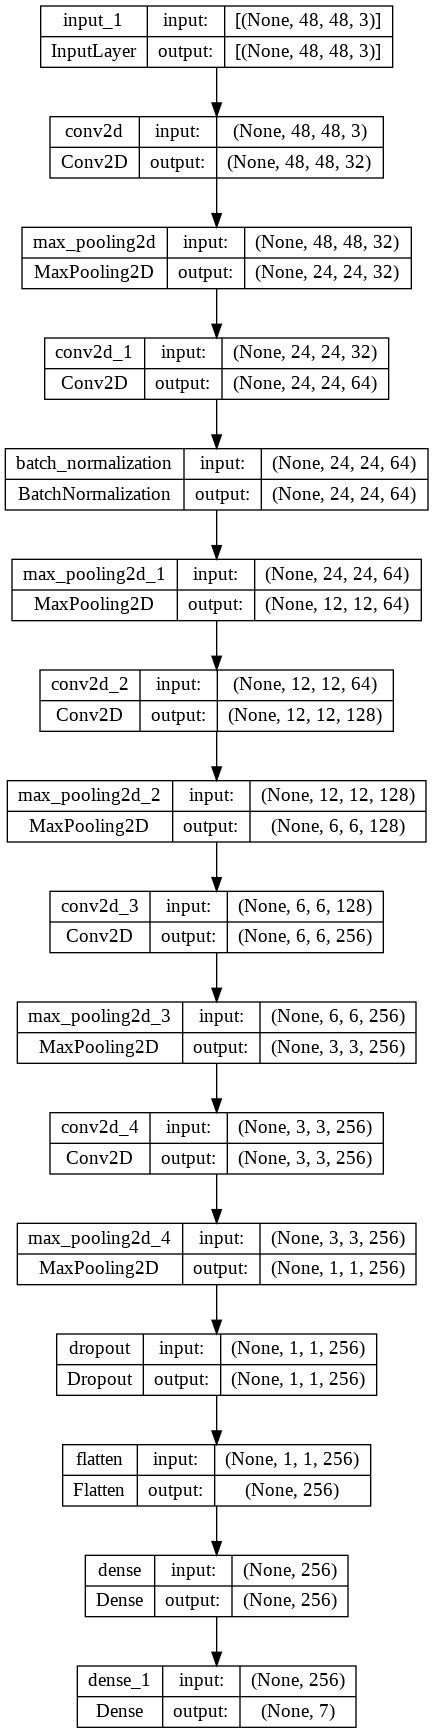

In [ ]:
#Visualizing the model created
plot_model(model, to_file='train_model.png', show_shapes=True)

In [ ]:
#Model Compilation
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

EPOCHS = 50

es= EarlyStopping(monitor='val_loss', mode='min', patience=4)
cp= ModelCheckpoint('emotion.h5',save_best_only=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0     

In [ ]:
# Training the model with 50 epochs
history = model.fit(
    processed_train_data,
    processed_target_train,
    steps_per_epoch=int(np.ceil(len(processed_train_data) / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    validation_steps=int(np.ceil(len(X_test) / float(BATCH_SIZE)))
    )

Epoch 1/50
1020/1020 [==============================] - 17s 14ms/step - loss: 1.7288 - accuracy: 0.3068 - val_loss: 1.5294 - val_accuracy: 0.4134
Epoch 2/50
1020/1020 [==============================] - 11s 11ms/step - loss: 1.4624 - accuracy: 0.4392 - val_loss: 1.5330 - val_accuracy: 0.4363
Epoch 3/50
1020/1020 [==============================] - 11s 11ms/step - loss: 1.3528 - accuracy: 0.4866 - val_loss: 1.2583 - val_accuracy: 0.5217
Epoch 4/50
1020/1020 [==============================] - 11s 11ms/step - loss: 1.2785 - accuracy: 0.5140 - val_loss: 1.2586 - val_accuracy: 0.5178
Epoch 5/50
1020/1020 [==============================] - 11s 11ms/step - loss: 1.2265 - accuracy: 0.5375 - val_loss: 1.2399 - val_accuracy: 0.5321
Epoch 6/50
1020/1020 [==============================] - 11s 11ms/step - loss: 1.1760 - accuracy: 0.5596 - val_loss: 1.1818 - val_accuracy: 0.5555
Epoch 7/50
1020/1020 [==============================] - 11s 11ms/step - loss: 1.1345 - accuracy: 0.5736 - val_loss: 1.1072 -

In [ ]:
# Saving the model
model_json = model.to_json()
with open("emotion_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("emotion_model_weight.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# Loading the model architecture and assigning the weights
json_file = open('emotion_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(loaded_model_json)
# Load weights into new model
model_loaded.load_weights("emotion_model_weight.h5")

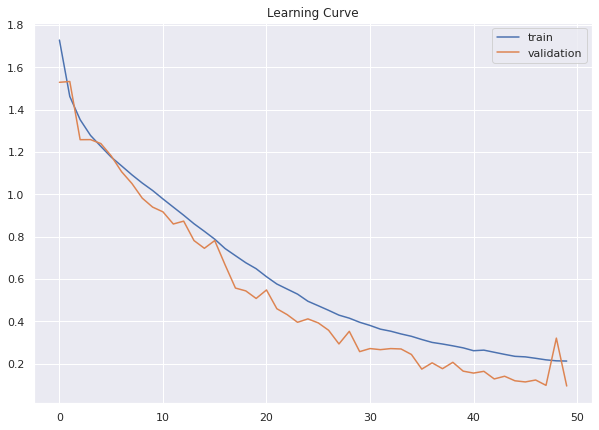

In [ ]:
# Plot to show the loss between the train and validation data
ax = plt.axes()
sns.set(rc = {'figure.figsize':(10,7)})
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='validation') 
pyplot.legend() 
pyplot.title("Learning Curve")
pyplot.show()

## Model Testing

In [ ]:
# Loading the whole dataset for testing the model
emotion_data_test = pd.read_csv('emotion_data.csv')

In [ ]:
emotion_data_test.head(2)

,path,emotion_label
0,train/angry/Training_54806380.jpg,0
1,train/angry/Training_86750647.jpg,0


In [ ]:
emotion_data_test.shape

(35894, 2)

In [ ]:
# Function to convert the images into an array
from multiprocessing import Pool
progress = tqdm(total= len(emotion_data['path']), position=0)
def read(path):
  img = tf.keras.utils.load_img(path, target_size=(48,48,3))
  img = tf.keras.utils.img_to_array(img)
  img = img/255.
  progress.update(1)
  return img

p = Pool(10)
img_array = p.map(read, emotion_data['path'])

In [ ]:
with open('emotion_image_test.pickle','wb') as f:
  pickle.dump(img_array, f)

In [ ]:
with open('emotion_image_test.pickle','rb') as f:
  img_array = pickle.load(f)

In [ ]:
X = img_array
y = emotion_data_test['emotion_label'].values

(<matplotlib.image.AxesImage at 0x7fcf53a61dc0>, 3)

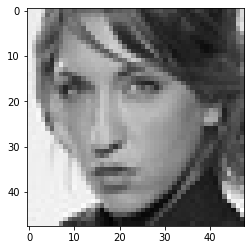

In [ ]:
plt.imshow(X[11234]),y[11234]

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
X.shape, y.shape

((35894, 48, 48, 3), (35894,))

In [ ]:
# loading the model architecture and asigning the weights
json_file = open('emotion_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(loaded_model_json)
# load weights into new model
model_loaded.load_weights("emotion_model_weight.h5")

In [ ]:
test = model_loaded.predict(X)

1122/1122 [==============================] - 10s 2ms/step


In [ ]:
test

array([[0.9999689 , 0.48685676, 0.47634745, ..., 0.07838454, 0.48118556,
        0.41338822],
       [0.99999917, 0.05007236, 0.99994683, ..., 0.00222324, 0.4437762 ,
        0.32677516],
       [0.99999785, 0.6586285 , 0.9400593 , ..., 0.02723288, 0.31086895,
        0.6418641 ],
       ...,
       [0.98606515, 0.14511001, 0.8286864 , ..., 0.88560313, 0.19074707,
        0.99982136],
       [0.48649433, 0.64319485, 0.834772  , ..., 0.21783783, 0.4915628 ,
        0.5779055 ],
       [0.9388864 , 0.13463724, 0.91131103, ..., 0.89394176, 0.5018802 ,
        0.9949309 ]], dtype=float32)

In [ ]:
#Finds the maximum values in the image array to assign emotion label
def find_max(check_array):
  return check_array.tolist().index(max(check_array))

In [ ]:
#Loop to get the maximum values for each image and append the values into the result array
result = []
for i in test:
    max(i)
    result.append(find_max(i))

In [ ]:
emotion_data_test['predicted_emotion_label'] = result

In [ ]:
emotion_data_test.head(3)

,path,emotion_label,predicted_emotion_label
0,train/angry/Training_54806380.jpg,0,0
1,train/angry/Training_86750647.jpg,0,0
2,train/angry/Training_58773233.jpg,0,0


In [ ]:
#emotion_data_test.to_csv('predicted_emotion_data.csv', index = False)

In [ ]:
#To check if the emotion label matches the predicted emotion
emotion_data_test['equality'] = np.where((emotion_data_test['emotion_label'] == emotion_data_test['predicted_emotion_label']), True, False)

In [ ]:
emotion_data_test['equality'].value_counts()

True     28259
False     7635
Name: equality, dtype: int64

In [ ]:
#Replacing the label with actual emotion
emotion_data_test = emotion_data_test.replace({'emotion_label': {0:"anger", 1:'disgust', 2:'fear', 3:'happy', 4:'neutral', 5:'surprise', 6:'sad'}})
emotion_data_test = emotion_data_test.replace({'predicted_emotion_label': {0:"anger", 1:'disgust', 2:'fear', 3:'happy', 4:'neutral', 5:'surprise', 6:'sad'}})

In [ ]:
emotion_data_test.head(2)

,path,emotion_label,predicted_emotion_label,equality
0,train/angry/Training_54806380.jpg,anger,anger,True
1,train/angry/Training_86750647.jpg,anger,anger,True


In [ ]:
labels = ['angry','disgust','fear','happy','neutral','surprise','sad']

In [ ]:
#Confusion matrix to for the actual and predicted emotions
confusion_matrix = pd.crosstab(emotion_data_test['emotion_label'], emotion_data_test['predicted_emotion_label'], 
                               rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted  anger  disgust  fear  happy  neutral   sad  surprise
Actual                                                         
anger       3652       62   319    170      313   362        75
disgust       40      477    26      2        1     1         0
fear         283       51  3807    146      293   366       175
happy        131        9   199   8115      277   184        74
neutral      228        7   231    326     4852   402       152
sad          361       20   449    203      568  4419        64
surprise      53       10   444    157      323    78      2937


Text(0.5, 1.0, 'Testing Accuracy For Each Emotion')

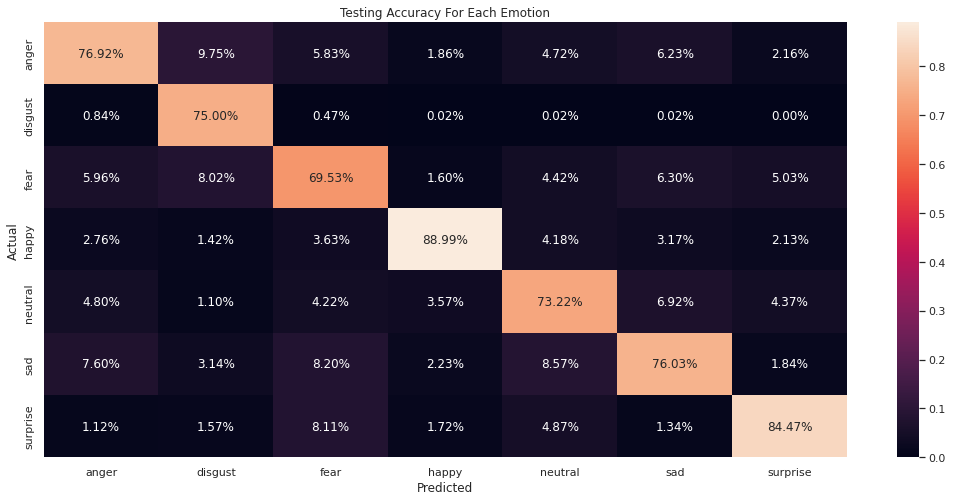

In [ ]:
#Heat map visualization for prediction
ax = plt.axes()
sns.set(rc = {'figure.figsize':(18,8)})
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), annot = True, fmt = '.2%', ax = ax)
ax.set_title('Testing Accuracy For Each Emotion')

## Testing the Model on Live Image

In [5]:
#Finds the maximum values in the image array to assign emotion label
def find_max(check_array):
  return check_array.tolist().index(max(check_array))

In [6]:
# loading the model architecture and asigning the weights
json_file = open('emotion_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(loaded_model_json)
# load weights into new model
model_loaded.load_weights("emotion_model_weight.h5")

In [7]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg
1/1 [==============================] - 0s 14ms/step
[0.47637102 0.03056788 0.9445631  0.8751024  0.8239232  0.14587376
 0.97324944]
6
0:anger, 1:disgust, 2:fear, 3:happy, 4:neutral, 5:surprise, 6:sad


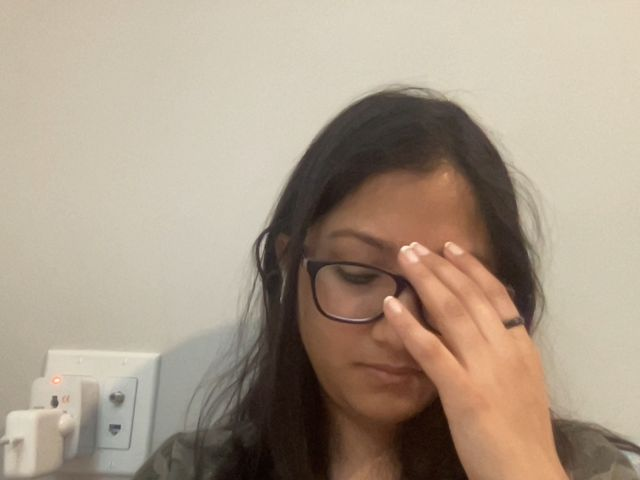

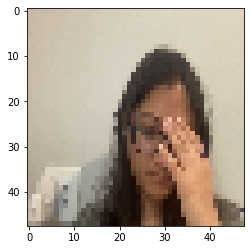

In [15]:
from IPython.display import Image
temp = []
i=0
  
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  img = tf.keras.utils.load_img(filename, target_size=(48,48,3))
  img = tf.keras.utils.img_to_array(img)
  img = img/255.
  img.shape
  temp.append(img)
  temp = np.array(temp)
  a = model_loaded.predict(temp)
  pyplot.imshow(temp[i])
  print(a[i])
  #max(a[i])
  print(find_max(a[i]))
  print("0:anger, 1:disgust, 2:fear, 3:happy, 4:neutral, 5:surprise, 6:sad")
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))